# Fichier visant à trouver le meilleur modèle de prédiction du flux de cyclistes passant aux abords des bornes de Rivoli et de Sébastopol

## Importation des bibliothèques

In [282]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_log_error

from tensorflow import keras

import math
import random
from scipy import stats


In [58]:
import warnings
warnings.filterwarnings("ignore")

models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),KNeighborsRegressor(),SVR()]

In [183]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow import keras
import sklearn.preprocessing

#regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import GradientBoostingRegressor

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn import pipeline , preprocessing

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification

## Récupération des dataset pour Rivoli et Sebastopol

In [1]:
%run Extract_data.ipynb

In [4]:
df_sebastopol,df_rivoli = get_dataset()

## Analyse des données

<Axes: title={'center': 'Sebastopol'}, xlabel='date'>

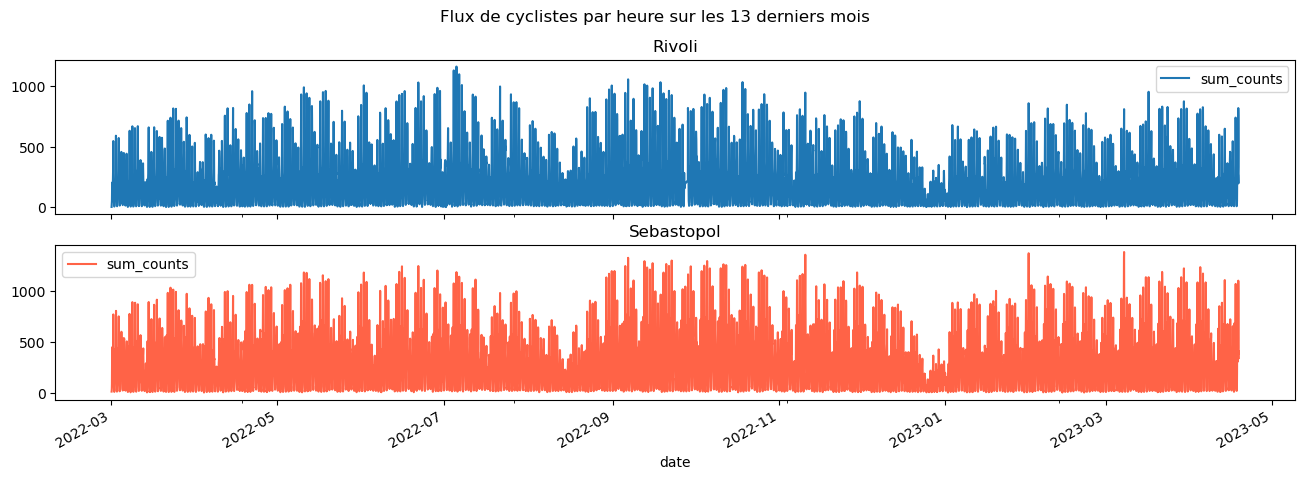

In [220]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(2, sharex=True ,figsize=(16,5))
fig.suptitle('Flux de cyclistes par heure sur les 13 derniers mois')
df_rivoli[['date','sum_counts']].plot(x='date',ax=ax1,title='Rivoli')
df_sebastopol[['date','sum_counts']].plot(x='date',ax=ax2,title = 'Sebastopol',color='tomato')

Text(0.5, 1.0, 'Sebastopol')

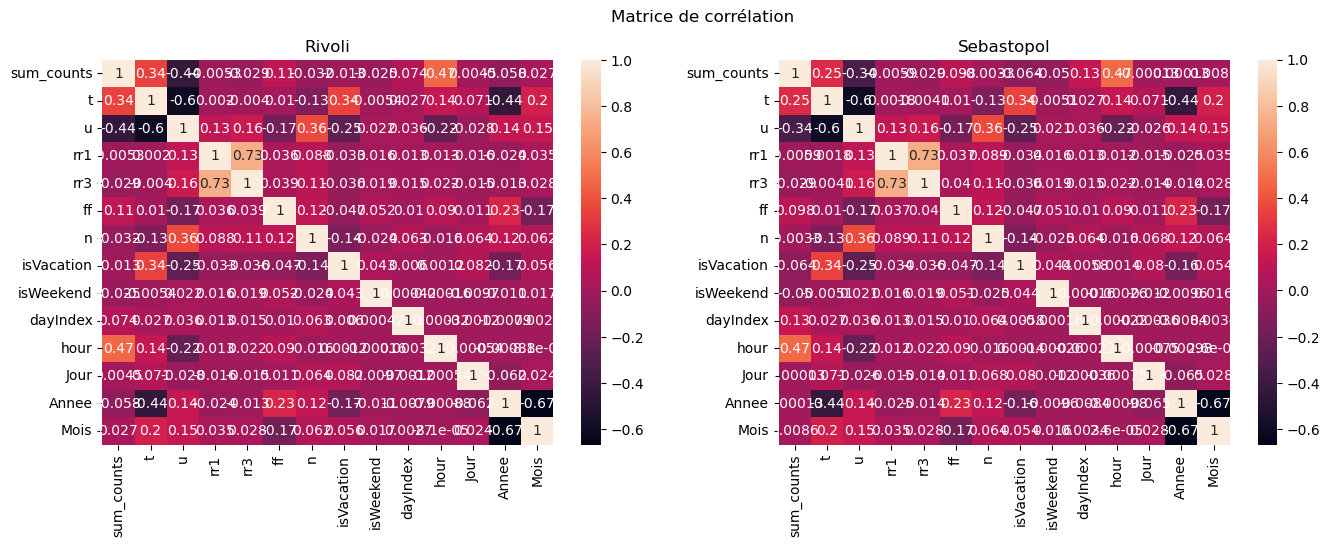

In [221]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
fig.suptitle('Matrice de corrélation')
correlationMatrix  = df_rivoli.drop(columns='date').corr()
sns.heatmap(correlationMatrix, annot=True,ax=ax1)
ax1.set_title('Rivoli')
correlationMatrix  = df_sebastopol.drop(columns='date').corr()
sns.heatmap(correlationMatrix, annot=True,ax=ax2)
ax2.set_title('Sebastopol')

[Text(0.5, 1.0, 'Humidité Sebastopol')]

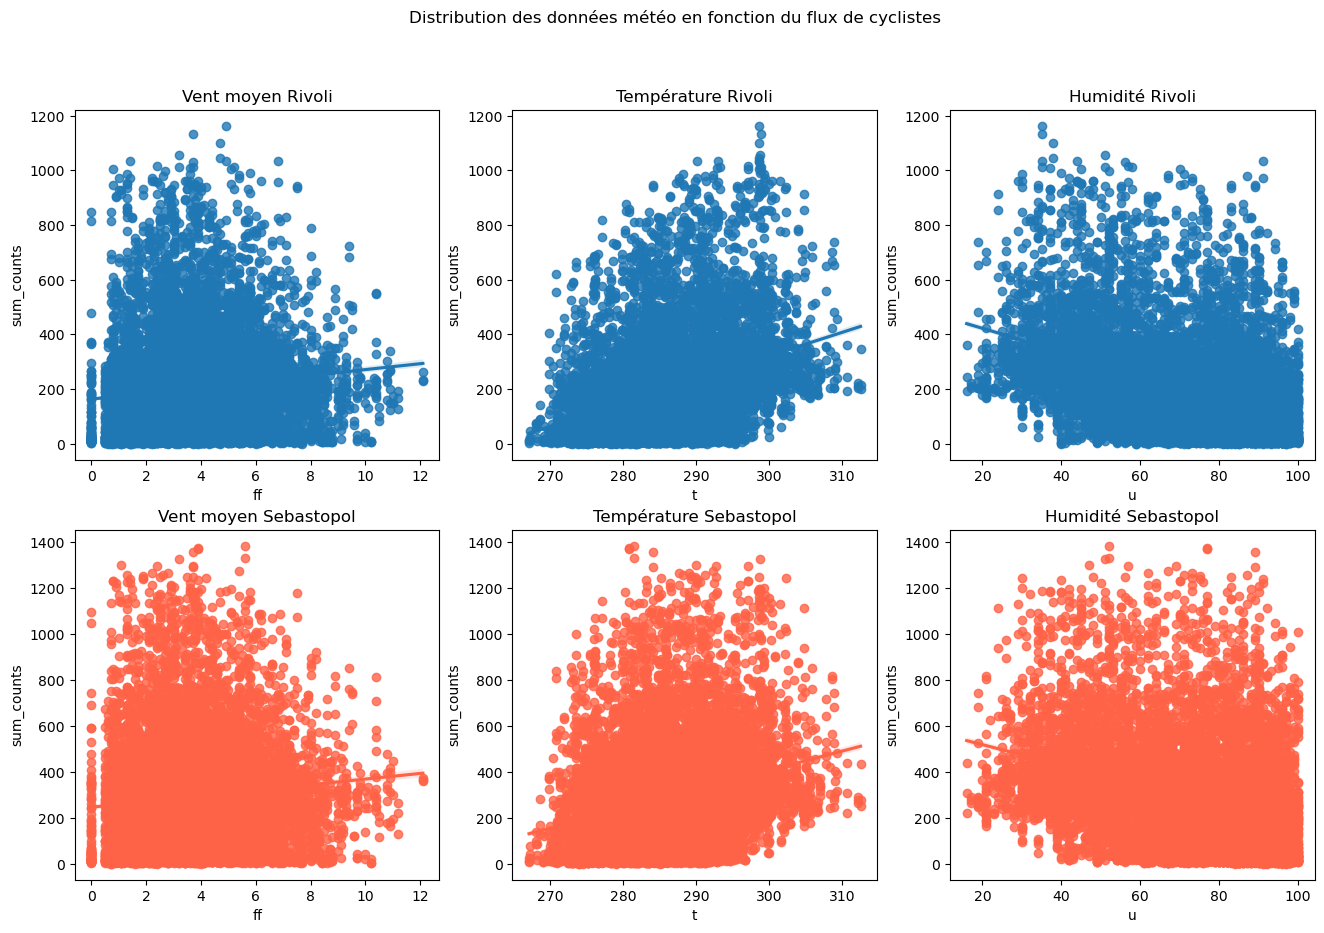

In [355]:
%matplotlib inline
fig,axes = plt.subplots(2,3 ,figsize=(16,10))
fig.suptitle('Distribution des données météo en fonction du flux de cyclistes')
sns.regplot(x="ff", y="sum_counts", data=df_rivoli,ax=axes[0][0]).set(title='Vent moyen Rivoli')
sns.regplot(x="t", y="sum_counts", data=df_rivoli,ax=axes[0][1]).set(title='Température Rivoli')
sns.regplot(x="u", y="sum_counts", data=df_rivoli,ax=axes[0][2]).set(title='Humidité Rivoli')
sns.regplot(x="ff", y="sum_counts", data=df_sebastopol,ax=axes[1][0],color='tomato').set(title='Vent moyen Sebastopol')
sns.regplot(x="t", y="sum_counts", data=df_sebastopol,ax=axes[1][1],color='tomato').set(title='Température Sebastopol')
sns.regplot(x="u", y="sum_counts", data=df_sebastopol,ax=axes[1][2],color='tomato').set(title='Humidité Sebastopol')

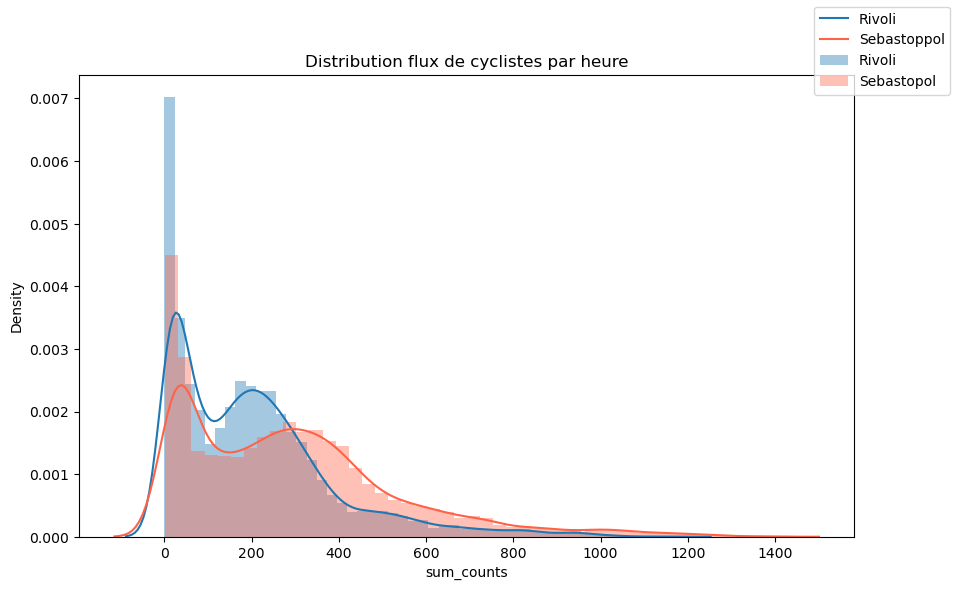

In [224]:
%matplotlib inline
fig = plt.figure(figsize=(10,6))
sns.distplot(df_rivoli["sum_counts"]).set_title('Distribution flux de cyclistes par heure')
sns.distplot(df_sebastopol["sum_counts"],color='tomato')
fig.legend(labels=['Rivoli','Sebastoppol','Rivoli','Sebastopol'])

Text(0.5, 1.0, 'Sebastopol')

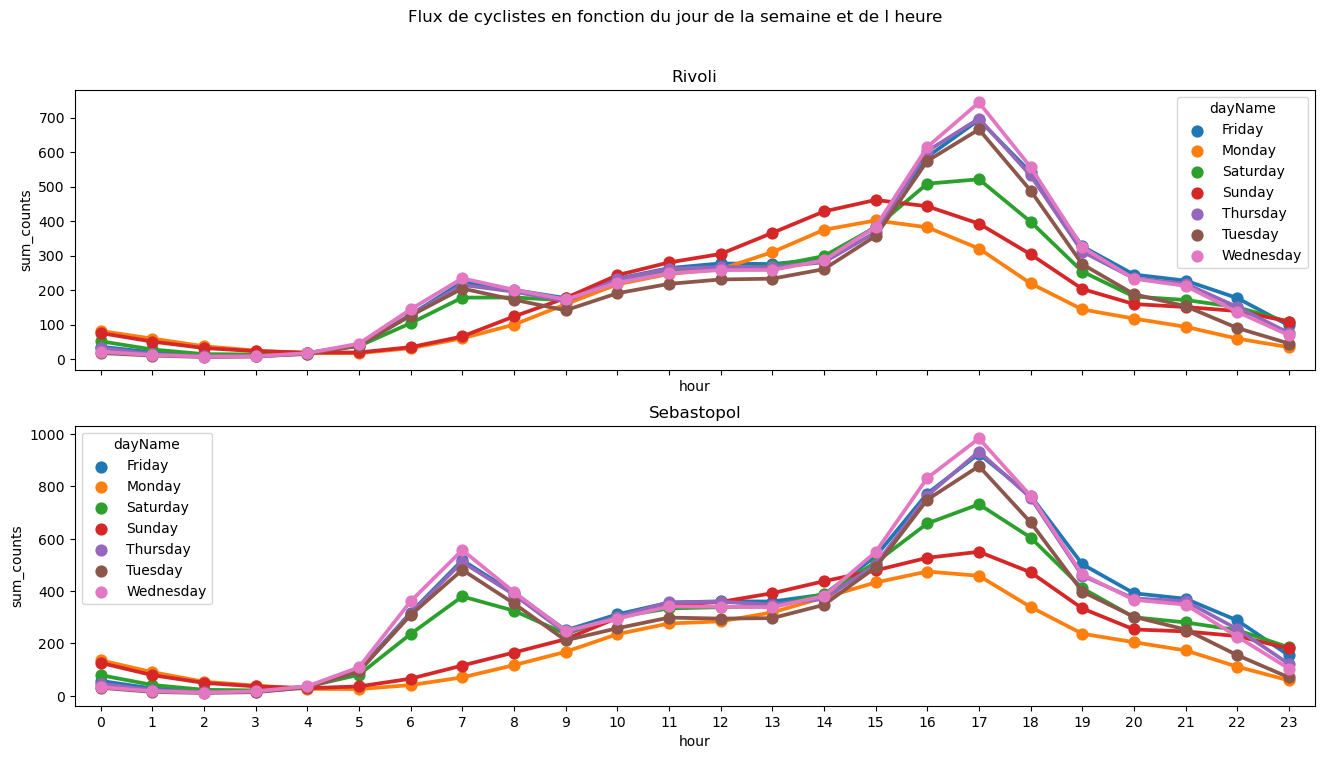

In [225]:
%matplotlib inline
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16,8))
fig.suptitle('Flux de cyclistes en fonction du jour de la semaine et de l heure')
df_rivoli['hour'] = df_rivoli['date'].dt.hour
hourAggregated = pd.DataFrame(df_rivoli.groupby(["hour","dayName"],sort=True)["sum_counts"].mean()).reset_index()

hourAggregated = pd.DataFrame(df_rivoli.groupby(["hour","dayName"],sort=True)["sum_counts"].mean()).reset_index()

sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["sum_counts"],hue=hourAggregated["dayName"]
              , data=hourAggregated,ax=ax1).set_title('Rivoli')

df_sebastopol['hour'] = df_sebastopol['date'].dt.hour
hourAggregated = pd.DataFrame(df_sebastopol.groupby(["hour","dayName"],sort=True)["sum_counts"].mean()).reset_index()

hourAggregated = pd.DataFrame(df_sebastopol.groupby(["hour","dayName"],sort=True)["sum_counts"].mean()).reset_index()

sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["sum_counts"],hue=hourAggregated["dayName"]
              , data=hourAggregated,ax=ax2).set_title('Sebastopol')

#  Préparation des données 

In [151]:
# Décomposition des dates et suppression des colonnes non int ou float
# Rivoli
df_rivoli_2 = df_rivoli
df_rivoli_2['Jour'] = df_rivoli_2['date'].dt.day
df_rivoli_2['Annee'] = df_rivoli_2['date'].dt.year
df_rivoli_2['Mois'] = df_rivoli_2['date'].dt.month
df_rivoli_2 = df_rivoli_2.drop(columns=['date','dayName']).reset_index(drop=True)

# Sebastopol
df_sebastopol_2 = df_sebastopol
df_sebastopol_2['Jour'] = df_sebastopol_2['date'].dt.day
df_sebastopol_2['Annee'] = df_sebastopol_2['date'].dt.year
df_sebastopol_2['Mois'] = df_sebastopol_2['date'].dt.month
df_sebastopol_2 = df_sebastopol_2.drop(columns=['date','dayName']).reset_index(drop=True)

In [152]:
# Création du dataset de train/test en prenant pour le test les 5 premiers jours pour Rivoli
x_train_rivoli = df_rivoli_2[df_rivoli_2['Jour'] >= 6].drop(columns='sum_counts')
y_train_rivoli = df_rivoli_2[df_rivoli_2['Jour'] >= 6]['sum_counts']
x_test_rivoli = df_rivoli_2[df_rivoli_2['Jour'] < 6].drop(columns='sum_counts')
y_test_rivoli = df_rivoli_2[df_rivoli_2['Jour'] < 6]['sum_counts']

In [169]:
# Création du dataset de train/test en prenant pour le test les 5 premiers jours pour Sebastopol
x_train_sebastopol = df_sebastopol_2[df_sebastopol_2['Jour'] >= 6].drop(columns='sum_counts')
y_train_sebastopol = df_sebastopol_2[df_sebastopol_2['Jour'] >= 6]['sum_counts']
x_test_sebastopol = df_sebastopol_2[df_sebastopol_2['Jour'] < 6].drop(columns='sum_counts')
y_test_sebastopol = df_sebastopol_2[df_sebastopol_2['Jour'] < 6]['sum_counts']

#  Test sur plusieurs algorithmes ML supervisés


In [178]:
# Test sur 5 algorithmes traitant des données temporelles cycliques
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),KNeighborsRegressor(),SVR()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','KNeighborsRegressor','SVR']*2
nom_station = ['Rivoli']*len(models) + ['Sebastopol']*len(models)

bornes = [[x_train_rivoli,y_train_rivoli,x_test_rivoli,y_test_rivoli],
          [x_train_sebastopol,y_train_sebastopol,x_test_sebastopol,y_test_sebastopol]]
rmse=[]
d={}
for borne in bornes:
    x_train = borne[0]
    y_train = borne[1]
    x_test = borne[2]
    y_test = borne[3]
    for model in range (len(models)):
        clf=models[model]
        clf.fit(x_train,y_train)
        test_pred=clf.predict(x_test)
        rmse.append(np.sqrt(mean_squared_log_error(test_pred,y_test)))
d={'Station':nom_station,'Modelling Algo':model_names,'RMSLE':rmse}   

<Figure size 1900x6000 with 0 Axes>

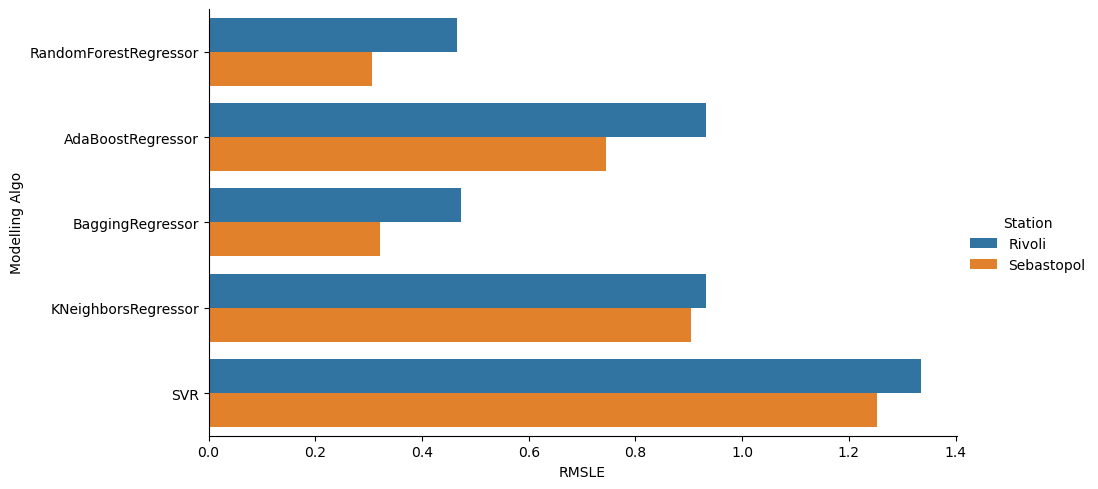

In [198]:
%matplotlib inline
fig = plt.figure(figsize=(19,60))
rmsle_frame=pd.DataFrame(d)
sns.catplot(y='Modelling Algo',x='RMSLE',data=rmsle_frame,kind='bar',hue='Station', height=5 ,aspect=2)


# Réseau de neurones

In [209]:
def machine_learning_model():

    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=50,input_shape=(training_set_sequence.shape[1], training_set_sequence.shape[2])))
    model.add(keras.layers.Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    model.summary()
    return model

In [201]:
def create_data_sequence(X, y, time_steps=1):

    input_sequence, output = [], []
    for i in range(len(X) - time_steps):
        sequence = X.iloc[i:(i + time_steps)].values
        input_sequence.append(sequence)        
        output.append(y.iloc[i + time_steps])
    return np.array(input_sequence), np.array(output)

In [202]:
training_set_sequence, training_set_output = create_data_sequence(x_train_rivoli, y_train_rivoli, 3)

In [211]:
# Utilisation des réseaux de neurones avec prise en compte de l'historique des 3 dernieres heures 

model = machine_learning_model()

history = model.fit(
    training_set_sequence,
    training_set_output, 
    epochs=300,  
    validation_split=0.1,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                12800     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12,851
Trainable params: 12,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
232/232 [==============================] - 2s 4ms/step - loss: 76634.2188 - val_loss: 69305.0000
Epoch 2/300
232/232 [==============================] - 1s 3ms/step - loss: 75526.3984 - val_loss: 68241.9297
Epoch 3/300
232/232 [==============================] - 1s 3ms/step - loss: 74439.3594 - val_loss: 67197.0859
Epoch 4/300
232/232 [==============================] - 1s 3ms/step - loss: 73372.8906 - val_loss: 66170.3359
Epoch 5/30

232/232 [==============================] - 1s 3ms/step - loss: 36769.1992 - val_loss: 31855.4961
Epoch 70/300
232/232 [==============================] - 1s 3ms/step - loss: 36629.2227 - val_loss: 31739.6953
Epoch 71/300
232/232 [==============================] - 1s 3ms/step - loss: 36498.0703 - val_loss: 31636.7480
Epoch 72/300
232/232 [==============================] - 1s 4ms/step - loss: 36377.4766 - val_loss: 31539.8203
Epoch 73/300
232/232 [==============================] - 1s 4ms/step - loss: 36266.2656 - val_loss: 31452.8555
Epoch 74/300
232/232 [==============================] - 1s 4ms/step - loss: 36161.9023 - val_loss: 31371.3223
Epoch 75/300
232/232 [==============================] - 1s 4ms/step - loss: 36066.2812 - val_loss: 31298.3867
Epoch 76/300
232/232 [==============================] - 1s 4ms/step - loss: 35978.2461 - val_loss: 31233.8301
Epoch 77/300
232/232 [==============================] - 1s 4ms/step - loss: 35898.1445 - val_loss: 31174.1172
Epoch 78/300
232/232 [=

232/232 [==============================] - 1s 3ms/step - loss: 35245.9727 - val_loss: 30850.4980
Epoch 144/300
232/232 [==============================] - 1s 3ms/step - loss: 35245.9961 - val_loss: 30850.4316
Epoch 145/300
232/232 [==============================] - 1s 3ms/step - loss: 35246.2773 - val_loss: 30850.6172
Epoch 146/300
232/232 [==============================] - 1s 3ms/step - loss: 35245.9844 - val_loss: 30850.5859
Epoch 147/300
232/232 [==============================] - 1s 3ms/step - loss: 35245.9844 - val_loss: 30850.6836
Epoch 148/300
232/232 [==============================] - 1s 3ms/step - loss: 35246.0859 - val_loss: 30851.3730
Epoch 149/300
232/232 [==============================] - 1s 3ms/step - loss: 35246.4102 - val_loss: 30851.3535
Epoch 150/300
232/232 [==============================] - 1s 3ms/step - loss: 35245.9180 - val_loss: 30851.0176
Epoch 151/300
232/232 [==============================] - 1s 3ms/step - loss: 35246.0547 - val_loss: 30850.9121
Epoch 152/300
2

Epoch 217/300
232/232 [==============================] - 1s 5ms/step - loss: 35246.0039 - val_loss: 30851.2422
Epoch 218/300
232/232 [==============================] - 1s 4ms/step - loss: 35246.0156 - val_loss: 30851.3125
Epoch 219/300
232/232 [==============================] - 1s 4ms/step - loss: 35246.2070 - val_loss: 30850.6191
Epoch 220/300
232/232 [==============================] - 1s 4ms/step - loss: 35246.0977 - val_loss: 30851.1582
Epoch 221/300
232/232 [==============================] - 1s 4ms/step - loss: 35246.0586 - val_loss: 30850.1387
Epoch 222/300
232/232 [==============================] - 1s 6ms/step - loss: 35246.0703 - val_loss: 30850.8770
Epoch 223/300
232/232 [==============================] - 1s 6ms/step - loss: 35245.9922 - val_loss: 30850.8164
Epoch 224/300
232/232 [==============================] - 2s 6ms/step - loss: 35245.9180 - val_loss: 30850.8184
Epoch 225/300
232/232 [==============================] - 2s 6ms/step - loss: 35246.1133 - val_loss: 30851.4160
E

Epoch 291/300
232/232 [==============================] - 2s 7ms/step - loss: 35246.0508 - val_loss: 30850.6094
Epoch 292/300
232/232 [==============================] - 1s 6ms/step - loss: 35246.0430 - val_loss: 30850.5645
Epoch 293/300
232/232 [==============================] - 1s 4ms/step - loss: 35246.0273 - val_loss: 30850.4668
Epoch 294/300
232/232 [==============================] - 1s 6ms/step - loss: 35246.0469 - val_loss: 30851.0430
Epoch 295/300
232/232 [==============================] - 1s 6ms/step - loss: 35246.1602 - val_loss: 30850.4668
Epoch 296/300
232/232 [==============================] - 1s 5ms/step - loss: 35246.0352 - val_loss: 30850.2910
Epoch 297/300
232/232 [==============================] - 1s 4ms/step - loss: 35245.9570 - val_loss: 30849.9414
Epoch 298/300
232/232 [==============================] - 1s 5ms/step - loss: 35246.0273 - val_loss: 30850.1016
Epoch 299/300
232/232 [==============================] - 1s 5ms/step - loss: 35246.0273 - val_loss: 30849.7324
E

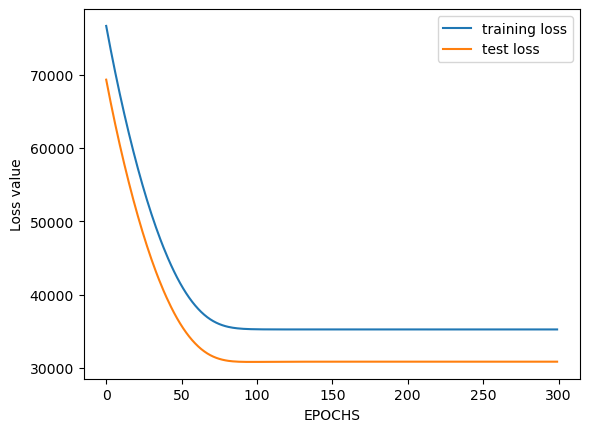

In [212]:
fig,ax = plt.subplots()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
ax.set_xlabel('EPOCHS')
ax.set_ylabel('Loss value')
plt.legend();

In [213]:
test_set_sequence, test_set_output = create_data_sequence(x_test_rivoli, y_test_rivoli, 3)

In [214]:
test_set_predictions = model.predict(test_set_sequence)


53/53 [==============================] - 1s 3ms/step


Text(0, 0.5, 'Vraie')

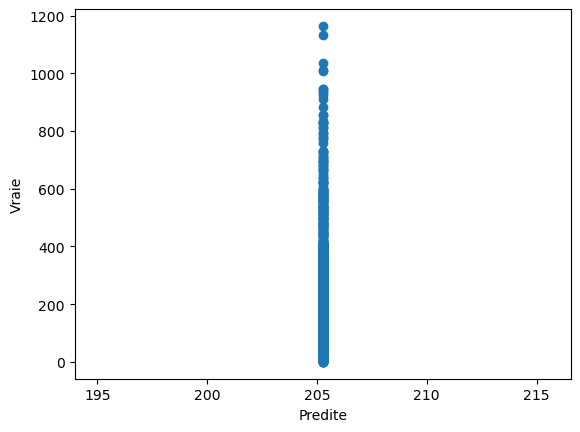

In [360]:
%matplotlib inline
plt.scatter(test_set_predictions,test_set_output)
plt.xlabel('Predite')
plt.ylabel('Vraie')

Modele peu convainquant

#  Amélioration de Random Forest Regressor

Utilisation du théorème du recuit simulé pour optimiser la recherche du meilleur estimateur de l'algorithme de Random Forest Regressor

In [ ]:
def f(x,y) :
    clf=RandomForestRegressor(n_estimators = x)
    clf.fit(x_train_rivoli,y_train_rivoli)
    test_pred=clf.predict(x_test_rivoli)
    RMSE_riv = (np.sqrt(mean_squared_log_error(test_pred,y_test_rivoli)))
    
    clf=RandomForestRegressor(n_estimators = y)
    clf.fit(x_train_sebastopol,y_train_sebastopol)
    test_pred=clf.predict(x_test_sebastopol)
    RMSE_seb = (np.sqrt(mean_squared_log_error(test_pred,y_test_sebastopol)))
    
    return(RMSE_riv + RMSE_seb)


In [271]:
def recuit_simule(x0, y0, T0, T_min = 1, alpha=0.9):
    x = x0
    y = y0
    T = T0
    x_best = 1
    y_best = 1
    f_best = f(x_best,y_best)
    
    while T > T_min:
        x_voisin = x + random.randint(-int(T), int(T))
        if x_voisin < 1 :
            x_voisin = 1

        y_voisin = y + random.randint(-int(T), int(T))
        if y_voisin < 1:
            y_voisin = 1 
            
            
        delta = f(x_voisin, y_voisin) - f(x, y)
        print(f(x_voisin, y_voisin),x,y,delta,T)
        if delta < 0:
            x = x_voisin
            y = y_voisin
            
            if f(x,y)<f(x_best,y_best):
                x_best = x
                y_best = y
                f_best = f(x,y)
        else:
            p = math.exp(-delta/T)
            if random.random() < p:
                x = x_voisin
                y = y_voisin
                
        T *= alpha
    
    return (x, y)

In [272]:
recuit_simule(10,10,40)

0.7738518954990988 10 10 -0.017074714523910073 40
0.7751949334804801 40 42 -0.0010069141612270016 36.0
0.769259479936931 69 54 0.001564088294253363 32.4
0.7724967516612421 74 67 -0.004295101346698416 29.16
0.7729096783616807 83 94 0.0015865774141532452 26.244
0.7711528248929097 69 112 0.002114393370337364 23.619600000000002
0.7738757498517808 89 129 0.002971281012821403 21.257640000000002
0.7744842964575047 88 114 0.0027994559744359826 19.131876000000002
0.7696819211182363 73 99 -0.0026906347809911857 17.2186884
0.7728473314568803 78 97 -0.0009958846750584005 15.496819560000002
0.7732197239656957 93 86 -0.0015721594485088586 13.947137604000002
0.7727524916676403 85 86 -0.0031038751685672494 12.552423843600002
0.7735368947714576 90 86 0.0013202057452902372 11.29718145924
0.7708038388248739 87 80 -0.0025509364274329815 10.167463313316
0.7706314264732883 86 85 0.0016809542394558008 9.1507169819844
0.7756014771892599 94 85 -0.0025724567982694513 8.23564528378596
0.7725116866807127 99 77 -0

(83, 56)

In [304]:
# Prédiction des valeurs de test avec le meilleur estimateur pour rivoli
clf=RandomForestRegressor(n_estimators = 83)
clf.fit(x_train_rivoli,y_train_rivoli)
test_pred_rivoli=clf.predict(x_test_rivoli)
print('RMSE = ',(np.sqrt(mean_squared_log_error(test_pred_rivoli,y_test_rivoli))))

RMSE =  0.4641515024138173


In [305]:
# Prédiction des valeurs de test avec le meilleur estimateur pour Sebastopol
clf=RandomForestRegressor(n_estimators = 56)
clf.fit(x_train_sebastopol,y_train_sebastopol)
test_pred_sebastopol=clf.predict(x_test_sebastopol)
print('RMSE = ',(np.sqrt(mean_squared_log_error(test_pred_sebastopol,y_test_sebastopol))))

RMSE =  0.3079133370414676


Text(0, 0.5, 'Vraie')

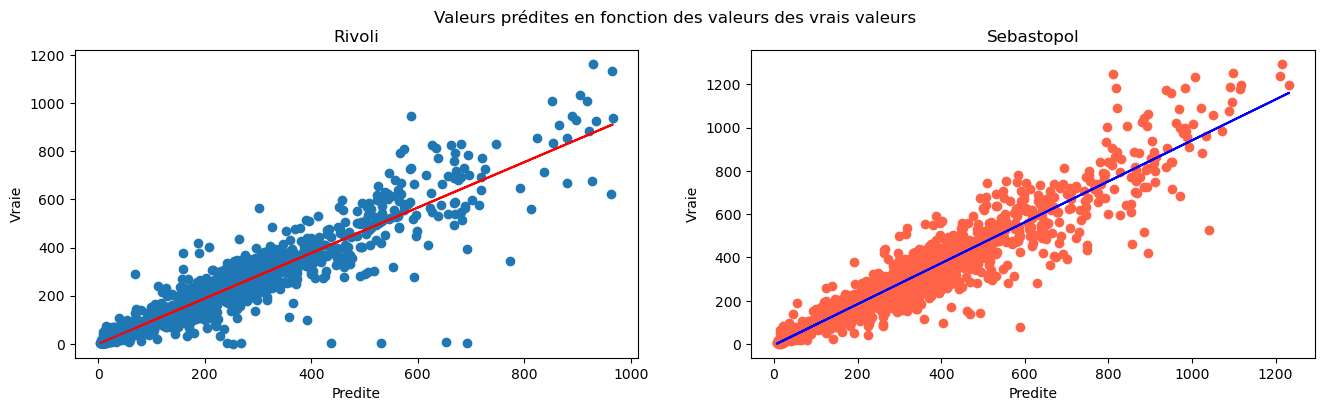

In [343]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
fig.suptitle('Valeurs prédites en fonction des valeurs des vrais valeurs')

ax1.scatter(test_pred_rivoli,y_test_rivoli)
slope, intercept, r_value, p_value, std_err = stats.linregress(test_pred_rivoli,y_test_rivoli)
fitLine = slope * test_pred_rivoli + intercept
ax1.plot(test_pred_rivoli, fitLine, c='r')
ax1.set_title('Rivoli')
ax1.set_xlabel('Predite')
ax1.set_ylabel('Vraie')

ax2.scatter(test_pred_sebastopol,y_test_sebastopol,color='tomato')
slope, intercept, r_value, p_value, std_err = stats.linregress(test_pred_sebastopol,y_test_sebastopol)
fitLine = slope * test_pred_sebastopol + intercept
ax2.plot(test_pred_sebastopol, fitLine, c='b')
ax2.set_title('Sebastopol')
ax2.set_xlabel('Predite')
ax2.set_ylabel('Vraie')

<IPython.core.display.Javascript object>


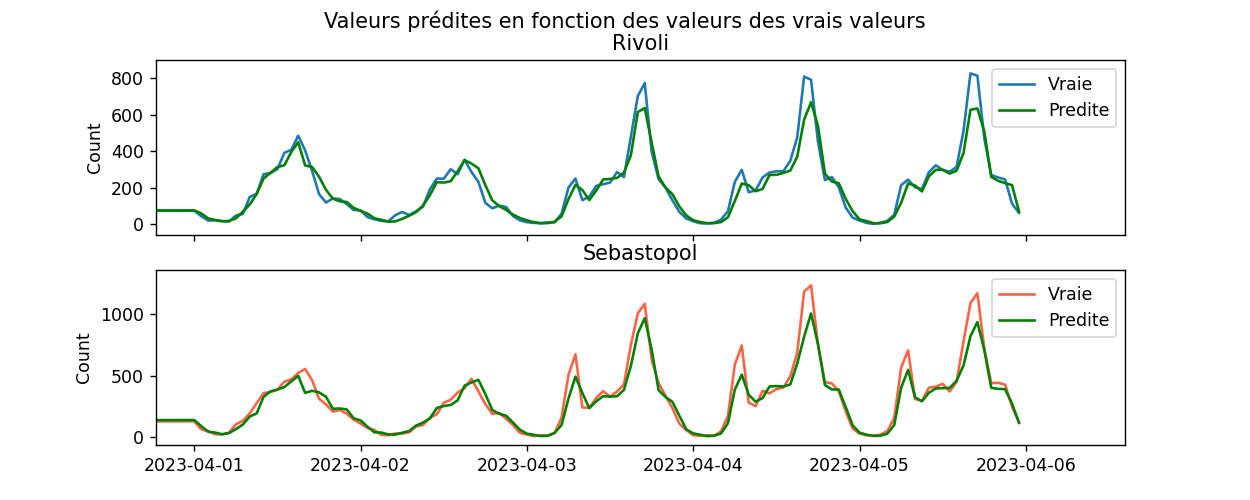

Text(0, 0.5, 'Count')

In [361]:
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,4), sharex=True)
fig.suptitle('Valeurs prédites en fonction des valeurs des vrais valeurs')

ax1.plot(x_test_rivoli[['Jour','Annee']].join(df_rivoli['date'].reset_index(drop=True))['date'],y_test_rivoli)
ax1.plot(x_test_rivoli[['Jour','Annee']].join(df_rivoli['date'].reset_index(drop=True))['date'],test_pred_rivoli,'g')
ax1.set_title('Rivoli')
ax1.legend(['Vraie','Predite'])
ax1.set_ylabel('Count')

ax2.plot(x_test_sebastopol[['Jour','Annee']].join(df_sebastopol['date'].reset_index(drop=True))['date'],y_test_sebastopol,color='tomato')
ax2.plot(x_test_sebastopol[['Jour','Annee']].join(df_sebastopol['date'].reset_index(drop=True))['date'],test_pred_sebastopol,'g')
ax2.set_title('Sebastopol')
ax2.legend(['Vraie','Predite'])
ax2.set_ylabel('Count')
